In [1]:
!pip3 install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 25.0.1
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Ellipse
import seaborn as sns
import glob
from scipy.spatial import ConvexHull
from scipy.optimize import linear_sum_assignment
from scipy.stats import multivariate_normal
from scipy.spatial import Delaunay
from sklearn.cluster import KMeans
import warnings
import json
import networkx as nx
warnings.simplefilter(action='ignore', category=FutureWarning)
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
from scipy.linalg import sqrtm
from scipy.optimize import linear_sum_assignment
from utils import *
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")


In [3]:
def wasserstein_distance_gaussian(mean1, cov1, mean2, cov2):
    # Compute the squared difference between the means.
    mean_diff_sq = np.linalg.norm(mean1 - mean2)**2

    # Compute the matrix square root of cov1
    cov1_sqrt = sqrtm(cov1)
    
    # Compute the product cov1_sqrt * cov2 * cov1_sqrt
    product = cov1_sqrt @ cov2 @ cov1_sqrt
    
    # Compute the square root of the product matrix
    sqrt_product = sqrtm(product)
    
    # Compute the trace term
    trace_term = np.trace(cov1 + cov2 - 2 * sqrt_product)
    
    # Return the 2-Wasserstein distance (ensure non-negative)
    return np.sqrt(max(mean_diff_sq + trace_term, 0))


In [4]:
def compute_emd(formation1, formation2):
    n = len(formation1)
    m = len(formation2)
    cost_matrix = np.zeros((n, m))
    
    for i in range(n):
        for j in range(m):
            mean1, cov1 = formation1[i]
            mean2, cov2 = formation2[j]
            cost_matrix[i, j] = wasserstein_distance_gaussian(mean1, cov1, mean2, cov2)
    
    
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    total_cost = cost_matrix[row_ind, col_ind].sum()
    
    return total_cost


In [5]:
# with open('tracks.json', 'r') as f:
#     tracks_z14 = json.load(f)

with open('tracks.json', 'r') as f:
    tracks_z14 = json.load(f)

with open('extern_adjusted_tracks_mirrored_5min_window.json', 'r') as f:
    tracks_extern = json.load(f)

with open('adjusted_tracks_mirroed_5-10min_window_2.json', 'r') as f:
    tracks_extern_2 = json.load(f)

In [6]:
# Merge the two JSON structures
combined_data = {**tracks_z14, **tracks_extern, **tracks_extern_2}

with open("merged.json", "w") as output_file:
    json.dump(combined_data, output_file, indent=4)

print("Merged JSON saved as 'merged.json'")


Merged JSON saved as 'merged.json'


In [7]:
formations = []  
team_names = []  

for team, roles in combined_data.items():
    for role_key, players in roles.items():
        if not players:  # Skip if the role is an empty object
            continue
        formation = []
        for player, stats in players.items():
            mean = np.array(stats['mean'])          
            covariance = np.array(stats['covariance']) 
            formation.append((mean, covariance))
        formations.append(formation)
        team_names.append(f"{team}_{role_key}")

num_formations = len(formations)
print(f"Number of formations: {num_formations}")
distance_matrix = np.zeros((num_formations, num_formations))

for i in range(num_formations):
    for j in range(i + 1, num_formations):
        distance = compute_emd(formations[i], formations[j])
        distance_matrix[i, j] = distance
        distance_matrix[j, i] = distance  # distance is symmetric


Number of formations: 57


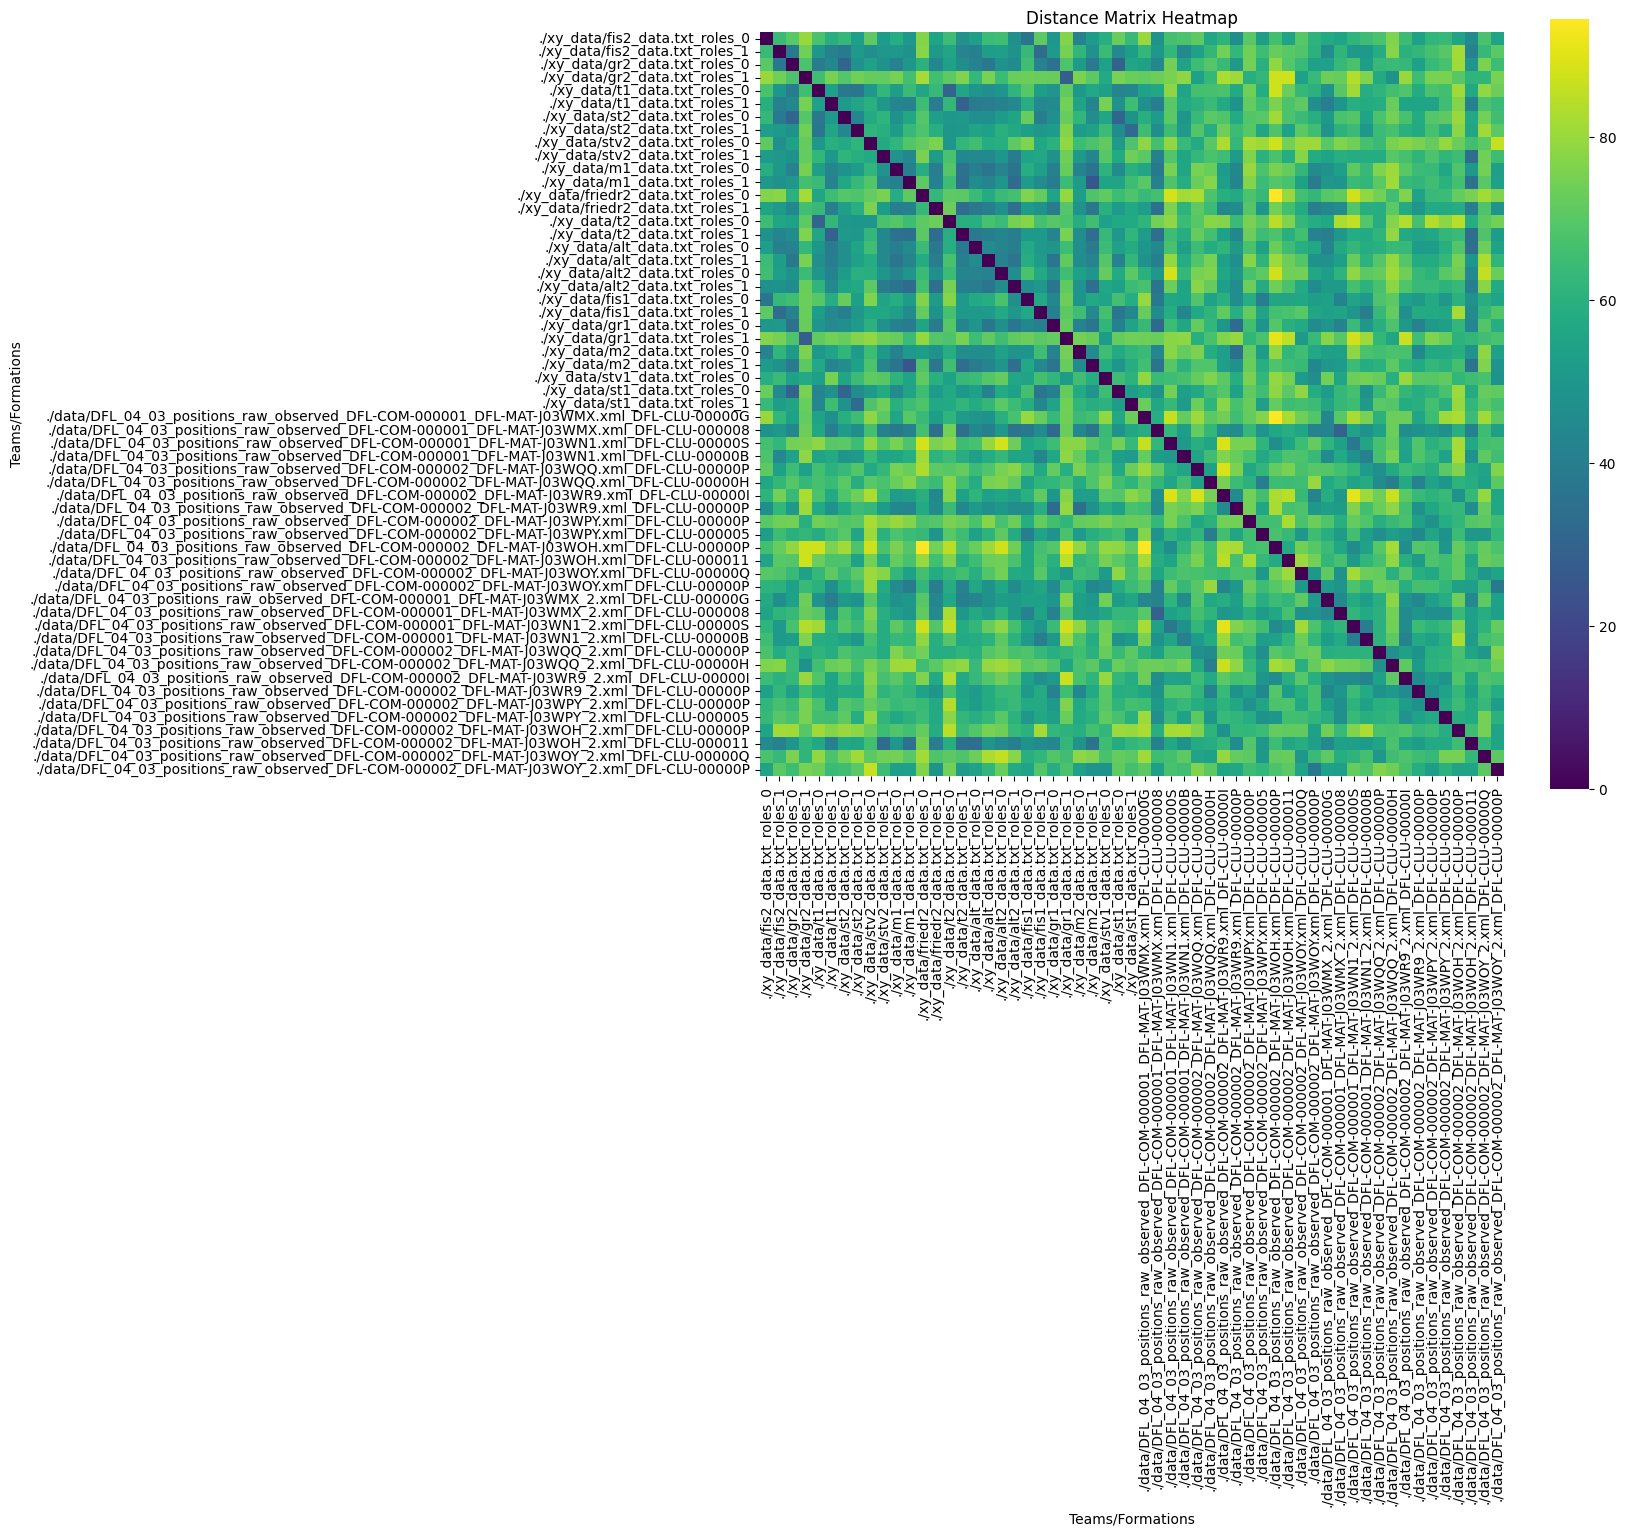

In [8]:
import seaborn as sns

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(distance_matrix, cmap='viridis', xticklabels=team_names, yticklabels=team_names, square=True)
plt.title("Distance Matrix Heatmap")
plt.xlabel("Teams/Formations")
plt.ylabel("Teams/Formations")

plt.show()

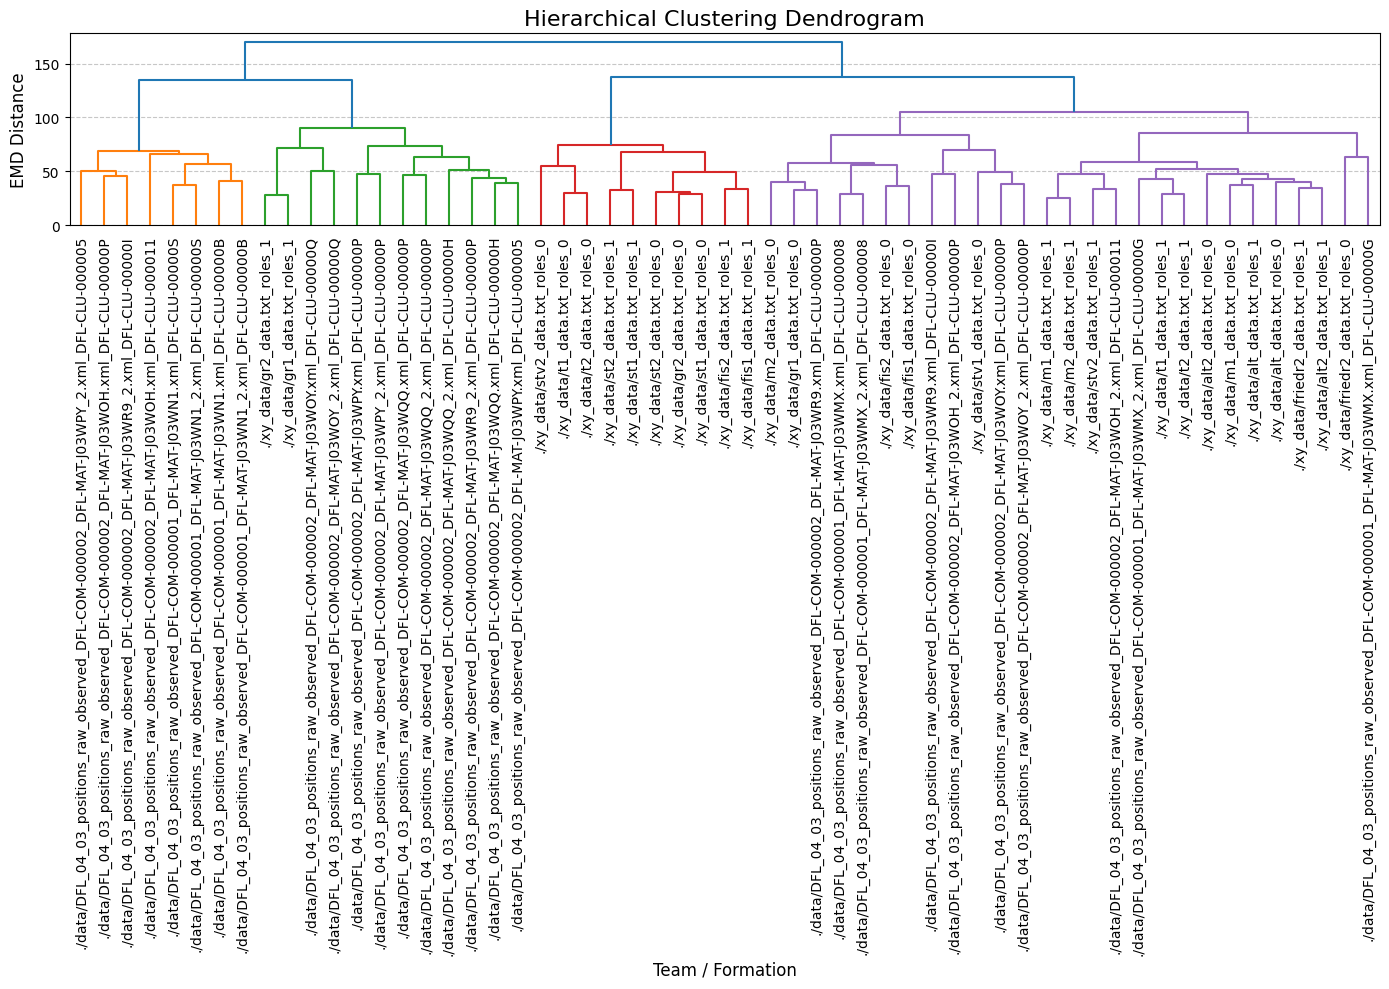

In [9]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt

condensed_distance = squareform(distance_matrix)
linkage_matrix = linkage(condensed_distance, method='ward')

# Plot the dendrogram
plt.figure(figsize=(14, 10))  
dendrogram(
    linkage_matrix,
    labels=team_names,
    leaf_rotation=90,  
    leaf_font_size=10  
)
plt.title('Hierarchical Clustering Dendrogram', fontsize=16)
plt.xlabel('Team / Formation', fontsize=12)
plt.ylabel('EMD Distance', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [10]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(
    n_clusters=4,
    metric='euclidean',  
    linkage='ward' 
)

cluster_labels = clustering.fit_predict(distance_matrix)

for team, label in zip(team_names, cluster_labels):
    print(f"Team {team} is in cluster {label}")


Team ./xy_data/fis2_data.txt_roles_0 is in cluster 3
Team ./xy_data/fis2_data.txt_roles_1 is in cluster 1
Team ./xy_data/gr2_data.txt_roles_0 is in cluster 1
Team ./xy_data/gr2_data.txt_roles_1 is in cluster 0
Team ./xy_data/t1_data.txt_roles_0 is in cluster 1
Team ./xy_data/t1_data.txt_roles_1 is in cluster 2
Team ./xy_data/st2_data.txt_roles_0 is in cluster 1
Team ./xy_data/st2_data.txt_roles_1 is in cluster 1
Team ./xy_data/stv2_data.txt_roles_0 is in cluster 1
Team ./xy_data/stv2_data.txt_roles_1 is in cluster 2
Team ./xy_data/m1_data.txt_roles_0 is in cluster 2
Team ./xy_data/m1_data.txt_roles_1 is in cluster 2
Team ./xy_data/friedr2_data.txt_roles_0 is in cluster 1
Team ./xy_data/friedr2_data.txt_roles_1 is in cluster 2
Team ./xy_data/t2_data.txt_roles_0 is in cluster 1
Team ./xy_data/t2_data.txt_roles_1 is in cluster 2
Team ./xy_data/alt_data.txt_roles_0 is in cluster 2
Team ./xy_data/alt_data.txt_roles_1 is in cluster 2
Team ./xy_data/alt2_data.txt_roles_0 is in cluster 2
Team 

/Users/stefanbartl/Library/Python/3.9/lib/python/site-packages/scipy/cluster/hierarchy.py:796: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


## Turn means and covs to feature vectors

In [40]:
import json

with open("merged.json", "r") as file:  
    data = json.load(file)

team_feature_vectors = {}

for dataset_key, teams in data.items():
    team_feature_vectors[dataset_key] = {}  

    
    for team_key, players in teams.items():
        team_vector = []  

        # exactly 10 players in order
        player_keys = sorted(players.keys(), key=int)[:10] 

        for player_key in player_keys:
            player_data = players[player_key]
            mean = player_data["mean"]
            cov_matrix = player_data["covariance"]
            cov_vector = [cov_matrix[0][0], cov_matrix[0][1], cov_matrix[1][1]]

            player_vector = mean + cov_vector

            team_vector.extend(player_vector)

        # Store team vector
        team_feature_vectors[dataset_key][team_key] = team_vector




In [36]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report


with open("merged.json", "r") as file: 
    data = json.load(file)

ground_truth = {  
    ("./xy_data/alt2_data.txt", "roles_0"): 4231,
    ("./xy_data/alt2_data.txt", "roles_1"): 442,

    ("./xy_data/alt_data.txt", "roles_0"): 4231,
    ("./xy_data/alt_data.txt", "roles_1"): 442,

    ("./xy_data/fis1_data.txt", "roles_0"): 442,
    ("./xy_data/fis1_data.txt", "roles_1"): 4231,

    ("./xy_data/fis2_data.txt", "roles_0"): 442,
    ("./xy_data/fis2_data.txt", "roles_1"): 4231,

    ("./xy_data/fried1_data.txt", "roles_1"): 442,

    ("./xy_data/friedr2_data.txt", "roles_0"): 442,
    ("./xy_data/friedr2_data.txt", "roles_1"): 442,

    ("./xy_data/gr1_data.txt", "roles_0"): 4231,
    ("./xy_data/gr1_data.txt", "roles_1"): 352,

    ("./xy_data/gr2_data.txt", "roles_0"): 4231,
    ("./xy_data/gr2_data.txt", "roles_1"): 352,

    ("./xy_data/m1_data.txt", "roles_0"): 442,
    ("./xy_data/m1_data.txt", "roles_1"): 442,

    ("./xy_data/m2_data.txt", "roles_0"): 442,
    ("./xy_data/m2_data.txt", "roles_1"): 442,

    ("./xy_data/st1_data.txt", "roles_0"): 4231,
    ("./xy_data/st1_data.txt", "roles_1"): 4231,

    ("./xy_data/st2_data.txt", "roles_0"): 4231,
    ("./xy_data/st2_data.txt", "roles_1"): 4231,

    ("./xy_data/stv1_data.txt", "roles_0"): 4231,

    ("./xy_data/stv2_data.txt", "roles_0"): 352,
    ("./xy_data/stv2_data.txt", "roles_1"): 442,

    ("./xy_data/t1_data.txt", "roles_0"): 0,
    ("./xy_data/t1_data.txt", "roles_1"): 442,

    ("./xy_data/t2_data.txt", "roles_0"): 0,
    ("./xy_data/t2_data.txt", "roles_0"): 442,

    
   
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000001_DFL-MAT-J03WMX.xml', 'DFL-CLU-00000G'): 4231,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000001_DFL-MAT-J03WMX.xml', 'DFL-CLU-000008'): 4231,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000001_DFL-MAT-J03WN1.xml', 'DFL-CLU-00000B'): 4231,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000001_DFL-MAT-J03WN1.xml', 'DFL-CLU-00000S'): 0, #here 4332
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WQQ.xml', 'DFL-CLU-00000P'): 352,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WQQ.xml', 'DFL-CLU-00000H'): 352,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WR9.xml', 'DFL-CLU-00000I'): 4231,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WR9.xml', 'DFL-CLU-00000P'): 442, #here 4422
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WPY.xml', 'DFL-CLU-000005'): 0, #here 4132
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WPY.xml', 'DFL-CLU-00000P'): 4231,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WOH.xml', 'DFL-CLU-00000P'): 4231,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WOH.xml', 'DFL-CLU-000011'): 4231,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WOY.xml', 'DFL-CLU-00000P'): 4231,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WOY.xml', 'DFL-CLU-00000Q'): 352,
    #-------------------------
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000001_DFL-MAT-J03WMX_2.xml', 'DFL-CLU-00000G'): 4231,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000001_DFL-MAT-J03WMX_2.xml', 'DFL-CLU-000008'): 4231,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000001_DFL-MAT-J03WN1_2.xml', 'DFL-CLU-00000B'): 4231,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000001_DFL-MAT-J03WN1_2.xml', 'DFL-CLU-00000S'): 0, # Changed 4231 to 4332 here
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WQQ_2.xml', 'DFL-CLU-00000P'): 352,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WQQ_2.xml', 'DFL-CLU-00000H'): 352,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WR9_2.xml', 'DFL-CLU-00000I'): 4231,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WR9_2.xml', 'DFL-CLU-00000P'): 442, # Changed 442 to 4422 here
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WPY_2.xml', 'DFL-CLU-000005'): 0, # Changed 442 to 4132 here
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WPY_2.xml', 'DFL-CLU-00000P'): 4231,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WOH_2.xml', 'DFL-CLU-00000P'): 4231,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WOH_2.xml', 'DFL-CLU-000011'): 4231,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WOY_2.xml', 'DFL-CLU-00000P'): 4231,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WOY_2.xml', 'DFL-CLU-00000Q'): 352
}

ground_truth_balanced = {  
    # ("./xy_data/alt2_data.txt", "roles_0"): 4231,
    ("./xy_data/alt2_data.txt", "roles_1"): 442,

    # ("./xy_data/alt_data.txt", "roles_0"): 4231,
    # ("./xy_data/alt_data.txt", "roles_1"): 442,

    # ("./xy_data/fis1_data.txt", "roles_0"): 442,
    # ("./xy_data/fis1_data.txt", "roles_1"): 4231,

    # ("./xy_data/fis2_data.txt", "roles_0"): 442,
    ("./xy_data/fis2_data.txt", "roles_1"): 4231,

    ("./xy_data/fried1_data.txt", "roles_1"): 442,

    # ("./xy_data/friedr2_data.txt", "roles_0"): 442,
    ("./xy_data/friedr2_data.txt", "roles_1"): 442,

    # ("./xy_data/gr1_data.txt", "roles_0"): 4231,
    ("./xy_data/gr1_data.txt", "roles_1"): 352,

    # ("./xy_data/gr2_data.txt", "roles_0"): 4231,
    ("./xy_data/gr2_data.txt", "roles_1"): 352,

    ("./xy_data/m1_data.txt", "roles_0"): 442,
    # ("./xy_data/m1_data.txt", "roles_1"): 442,

    # ("./xy_data/m2_data.txt", "roles_0"): 442,
    ("./xy_data/m2_data.txt", "roles_1"): 442,

    # ("./xy_data/st1_data.txt", "roles_0"): 4231,
    # ("./xy_data/st1_data.txt", "roles_1"): 4231,

    ("./xy_data/st2_data.txt", "roles_0"): 4231,
    ("./xy_data/st2_data.txt", "roles_1"): 4231,

    ("./xy_data/stv1_data.txt", "roles_0"): 4231,

    ("./xy_data/stv2_data.txt", "roles_0"): 352,
    ("./xy_data/stv2_data.txt", "roles_1"): 442,

    ("./xy_data/t1_data.txt", "roles_0"): 0,
    ("./xy_data/t1_data.txt", "roles_1"): 442,

    ("./xy_data/t2_data.txt", "roles_0"): 0,
    ("./xy_data/t2_data.txt", "roles_0"): 442,

    
   
    # ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000001_DFL-MAT-J03WMX.xml', 'DFL-CLU-00000G'): 4231,
    # ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000001_DFL-MAT-J03WMX.xml', 'DFL-CLU-000008'): 4231,
    # ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000001_DFL-MAT-J03WN1.xml', 'DFL-CLU-00000B'): 4231,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000001_DFL-MAT-J03WN1.xml', 'DFL-CLU-00000S'): 0, #here 4332
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WQQ.xml', 'DFL-CLU-00000P'): 352,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WQQ.xml', 'DFL-CLU-00000H'): 352,
    # ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WR9.xml', 'DFL-CLU-00000I'): 4231,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WR9.xml', 'DFL-CLU-00000P'): 442, #here 4422
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WPY.xml', 'DFL-CLU-000005'): 0, #here 4132
    # ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WPY.xml', 'DFL-CLU-00000P'): 4231,
    # ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WOH.xml', 'DFL-CLU-00000P'): 4231,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WOH.xml', 'DFL-CLU-000011'): 4231,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WOY.xml', 'DFL-CLU-00000P'): 4231,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WOY.xml', 'DFL-CLU-00000Q'): 352,
    #-------------------------
    # ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000001_DFL-MAT-J03WMX_2.xml', 'DFL-CLU-00000G'): 4231,
    # ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000001_DFL-MAT-J03WMX_2.xml', 'DFL-CLU-000008'): 4231,
    # ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000001_DFL-MAT-J03WN1_2.xml', 'DFL-CLU-00000B'): 4231,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000001_DFL-MAT-J03WN1_2.xml', 'DFL-CLU-00000S'): 0, # Changed 4231 to 4332 here
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WQQ_2.xml', 'DFL-CLU-00000P'): 352,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WQQ_2.xml', 'DFL-CLU-00000H'): 352,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WR9_2.xml', 'DFL-CLU-00000I'): 4231,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WR9_2.xml', 'DFL-CLU-00000P'): 442, # Changed 442 to 4422 here
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WPY_2.xml', 'DFL-CLU-000005'): 0, # Changed 442 to 4132 here
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WPY_2.xml', 'DFL-CLU-00000P'): 4231,
    # ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WOH_2.xml', 'DFL-CLU-00000P'): 4231,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WOH_2.xml', 'DFL-CLU-000011'): 4231,
    # ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WOY_2.xml', 'DFL-CLU-00000P'): 4231,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WOY_2.xml', 'DFL-CLU-00000Q'): 352
}
# MEANS!!
# X, y = [], []
# team_feature_vectors = {}
# for dataset_key, teams in data.items():
#     team_feature_vectors[dataset_key] = {}
#     for team_key, players in teams.items():
#         means = []
#         covariances = []
#         # Ensure exactly 10 players in order
#         player_keys = sorted(players.keys(), key=int)[:10]
#         for player_key in player_keys:
#             player_data = players[player_key]
#             means.append(player_data["mean"])
#             covariances.append(player_data["covariance"])
#         if means and covariances:  # Ensure lists are not empty
#             # Step 1: Calculate the average mean vector
#             mean_total = np.mean(means, axis=0)
#             # Step 2: Calculate the average covariance matrix
#             covariance_total = np.mean(covariances, axis=0)
#             # Step 3: Flatten the covariance matrix and combine it with the mean
#             flattened_covariance = covariance_total.flatten()
#             # Combined feature vector
#             feature_vector = np.concatenate([mean_total, flattened_covariance])
#         else:
#             # Handle cases where means or covariances are empty
#             feature_vector = np.array([])  # Empty feature vector
#         # Store team vector
#         team_feature_vectors[dataset_key][team_key] = feature_vector

# for dataset, teams in team_feature_vectors.items():
#     for team, vector in teams.items():
#         if (dataset, team) in ground_truth:
#             X.append(vector)
#             y.append(ground_truth[(dataset, team)])
# X = np.array(X)
# y = np.array(y)


# NORMAL!!


X = []  # Feature matrix
y = []  # Labels
# Extract features and labels for each team
for (dataset_key, team_key), label in ground_truth_balanced.items():
    team_data = data.get(dataset_key, {}).get(team_key)
    if not team_data:
        print(f"Missing data for team {team_key} in dataset {dataset_key}. Skipping...")
        continue  # Skip if team data is missing
    # Initialize list for storing individual player feature vectors
    team_player_vectors = []
    # Process each player in the team
    for player_data in team_data.values():
        mean_x, mean_y = player_data["mean"]
        cov_xx, cov_xy = player_data["covariance"][0]
        _, cov_yy = player_data["covariance"][1] # because covariance is symmetric
        # Create a player vector with mean and covariance components
        player_vector = [mean_x, mean_y, cov_xx, cov_xy, cov_yy]
        team_player_vectors.extend(player_vector)  # Add to team vector
    # Append the team feature vector and its label
    X.append(team_player_vectors)
    y.append(label)
# Convert lists to NumPy arrays
X = np.array(X)
y = np.array(y)
print("Shape of feature matrix X:", X.shape)
print("Shape of label array y:", y.shape)





Missing data for team roles_1 in dataset ./xy_data/fried1_data.txt. Skipping...
Shape of feature matrix X: (32, 50)
Shape of label array y: (32,)


In [37]:
X[0]

array([-15.13697867,  -5.06249067,   9.57305294,   1.23961985,
         9.03094599,  19.27374806,   5.84360405,  37.48937269,
         2.79360541,  26.59765109,   9.67174133, -16.96209067,
        25.04693798,   6.28758449,  21.34870959, -10.97430033,
        15.67744685,  16.15548849,   1.29213787,  12.91788378,
        -0.38961867,  -5.35409067,  16.41393338,  -4.49259917,
        17.16342201, -12.99644891, -16.03339759,  23.60585537,
         1.29876305,   9.20936545, -14.57865867,   5.35134933,
        10.3511013 ,   0.70998608,   8.04180986,  18.81967578,
        -7.32757413,  33.63647127,   5.36591752,  18.0179798 ,
         8.65006604,  19.51599108,  19.30711835,  -4.30840378,
        30.06950088,  -1.80428469,   4.50549576,  13.85641349,
        -3.51618361,  17.68555421])

In [14]:
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler
# import matplotlib.pyplot as plt

# # Assuming X is your data matrix (57 samples x 50 features)
# # Standardize the data
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Apply PCA
# pca = PCA(n_components=20)  # You can choose the number of components you'd like (2 for visualization)
# X_pca = pca.fit_transform(X_scaled)

# # Explained variance ratio
# print("Explained variance by each component:", pca.explained_variance_ratio_)
# print("Total explained variance:", sum(pca.explained_variance_ratio_))

# # Map numeric labels to their names
# label_names = {442: "Label 442", 4231: "Label 4231", 352: "Label 352", 0: "Label 0"}
# label_colors = [label_names[label] for label in y]

# # Define a colormap with distinct colors
# cmap = plt.cm.get_cmap("tab10", len(label_names))  # Use 'tab10' for distinct colors
# colors = [cmap(i) for i in range(len(label_names))]

# # Create a mapping of labels to colors
# label_to_color = {label: colors[i] for i, label in enumerate(label_names.keys())}

# # Visualize the transformed data (if you reduce to 2 components)
# plt.figure(figsize=(8, 6))
# scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=[label_to_color[label] for label in y], label=label_colors)
# plt.colorbar(scatter, label="Labels")
# plt.title('PCA of 50-Dimensional Data (2 Components)')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')

# # Add legend for label names
# handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=label_to_color[label], markersize=10) for label in label_names]
# plt.legend(handles, label_names.values(), title="Labels")

# plt.show()


In [38]:
len(y)

32

In [16]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# scaler = StandardScaler()
# scaler.fit(X_train)

# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

In [17]:
# from sklearn.model_selection import GridSearchCV


# knn = KNeighborsClassifier()

# param_grid = {
#     'n_neighbors': [3, 5, 7, 9],
#     'weights': ['uniform', 'distance'],
#     'metric': ['euclidean', 'manhattan']
# }

# knn_cv = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

In [18]:
# knn_cv.fit(X_train, y_train)
# best_knn = knn_cv.best_estimator_
# print(f"Best parameters: {knn_cv.best_params_}")
# print(f"Best cross-validation score: {knn_cv.best_score_:.4f}")

In [19]:
# y_pred = best_knn.predict(X_test)
# test_accuracy = best_knn.score(X_test, y_test)
# print(f"Test accuracy: {test_accuracy:.4f}")


🔍 Running GridSearchCV for RandomForest...
Nested CV Accuracy: 0.2576

✅ RandomForest Results
Best Score (Mean CV Accuracy): 0.3788
Best Params: {'clf__max_depth': None, 'clf__n_estimators': 100}
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
         352       0.57      0.44      0.50         9
         442       0.46      0.67      0.55         9
        4231       0.18      0.22      0.20         9

    accuracy                           0.38        32
   macro avg       0.30      0.33      0.31        32
weighted avg       0.34      0.38      0.35        32



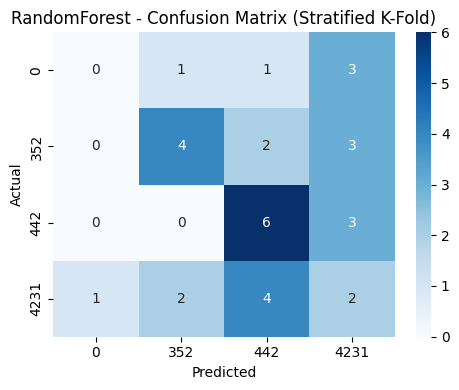


🔍 Running GridSearchCV for SVC...
Nested CV Accuracy: 0.3455

✅ SVC Results
Best Score (Mean CV Accuracy): 0.3455
Best Params: {'clf__C': 0.1, 'clf__kernel': 'linear'}
Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.20      0.25         5
         352       0.50      0.33      0.40         9
         442       0.38      0.56      0.45         9
        4231       0.20      0.22      0.21         9

    accuracy                           0.34        32
   macro avg       0.35      0.33      0.33        32
weighted avg       0.36      0.34      0.34        32



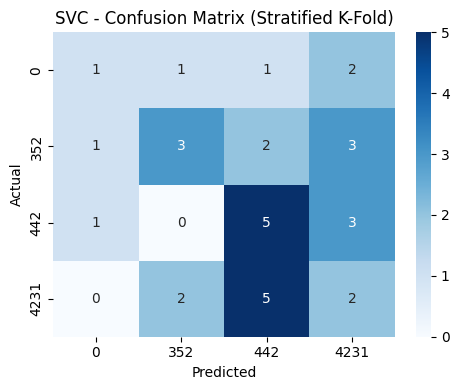


🔍 Running GridSearchCV for LogisticRegression...
Nested CV Accuracy: 0.2576

✅ LogisticRegression Results
Best Score (Mean CV Accuracy): 0.2909
Best Params: {'clf__C': 1, 'clf__solver': 'liblinear'}
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
         352       0.29      0.22      0.25         9
         442       0.42      0.56      0.48         9
        4231       0.18      0.22      0.20         9

    accuracy                           0.28        32
   macro avg       0.22      0.25      0.23        32
weighted avg       0.25      0.28      0.26        32



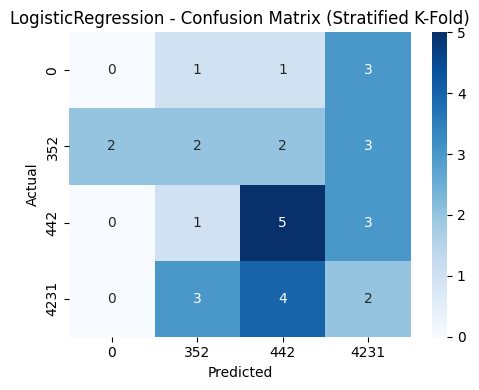


🔍 Running GridSearchCV for KNN...


/Users/stefanbartl/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/stefanbartl/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/stefanbartl/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/stefanbartl/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
  File "/Users/stefanbartl/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_scorer.py", line 89, in _cached_call
    result, _ = _get_response_values(
  File "/Users/stefanbartl

Nested CV Accuracy: 0.3424

✅ KNN Results
Best Score (Mean CV Accuracy): 0.5091
Best Params: {'clf__algorithm': 'auto', 'clf__leaf_size': 10, 'clf__metric': 'euclidean', 'clf__n_neighbors': 3, 'clf__weights': 'distance'}
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.40      0.44         5
         352       0.50      0.56      0.53         9
         442       0.50      0.44      0.47         9
        4231       0.50      0.56      0.53         9

    accuracy                           0.50        32
   macro avg       0.50      0.49      0.49        32
weighted avg       0.50      0.50      0.50        32



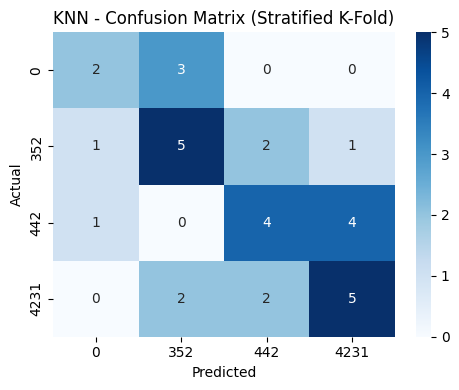

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# ==== Use Stratified K-Fold ====
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# ==== Define models with pipelines and parameter grids ====
models_and_parameters = {
    'RandomForest': {
        'pipeline': Pipeline([
            ('clf', RandomForestClassifier(random_state=42)) #class balanced
        ]),
        'params': {
            'clf__n_estimators': [10, 20, 30, 40, 50, 100],
            'clf__max_depth': [None, 5, 10, 15, 20, 30, 50]
        }
    },
    'SVC': {
        'pipeline': Pipeline([
          ('scaler', StandardScaler()),      
            ('clf', SVC())
        ]),
        'params': {
            'clf__C': [0.1, 1],
            'clf__kernel': ['linear', 'rbf']
        }
    },
    'LogisticRegression': {
        'pipeline': Pipeline([
           ('scaler', StandardScaler()),      
            ('clf', LogisticRegression(max_iter=1000))
        ]),
        'params': {
            'clf__C': [0.1, 1],
            'clf__solver': ['liblinear']
        }
    },
    'KNN': {
        'pipeline': Pipeline([
            
           ('scaler', StandardScaler()),      
            ('clf', KNeighborsClassifier())
        ]),
        'params': {
            'clf__n_neighbors': [3, 5, 7, 9, 11, 13, 15],
            'clf__metric': ['euclidean', 'manhattan', 'chebyshev'],
            'clf__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'clf__leaf_size': [10, 20, 30, 40, 50],
            'clf__weights': ['uniform', 'distance']
        }
    }
}

# ==== Run GridSearchCV and evaluate with StratifiedKFold ====
results = {}

for name, mp in models_and_parameters.items():
    print(f"\n🔍 Running GridSearchCV for {name}...")
    
    # Grid Search with StratifiedKFold
    grid = GridSearchCV(mp['pipeline'], mp['params'], cv=cv, scoring='accuracy', n_jobs=-1)
    grid.fit(X, y)
    
    best_model = grid.best_estimator_
    results[name] = {
        'best_score': grid.best_score_,
        'best_params': grid.best_params_,
        'best_estimator': best_model
    }
    
    # Predict using cross_val_predict for fair evaluation
    y_pred = cross_val_predict(grid.best_estimator_, X, y, cv=cv, method='predict')

    

    nested_score = cross_val_score(grid, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
    print(f"Nested CV Accuracy: {nested_score.mean():.4f}")


    
    # Confusion Matrix & Report
    cm = confusion_matrix(y, y_pred)
    print(f"\n✅ {name} Results")
    print(f"Best Score (Mean CV Accuracy): {grid.best_score_:.4f}")
    print(f"Best Params: {grid.best_params_}")
    print("Classification Report:")
    print(classification_report(y, y_pred))
    
    # Plot Confusion Matrix with true labels
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.title(f'{name} - Confusion Matrix (Stratified K-Fold)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()



🔍 Running GridSearchCV for RandomForest...

✅ RandomForest Results
Best Score (Mean CV Accuracy): 0.3125
Best Params: {'clf__max_depth': None, 'clf__n_estimators': 40}
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
         352       0.20      0.11      0.14         9
         442       0.38      0.67      0.48         9
        4231       0.33      0.33      0.33         9

    accuracy                           0.31        32
   macro avg       0.23      0.28      0.24        32
weighted avg       0.26      0.31      0.27        32



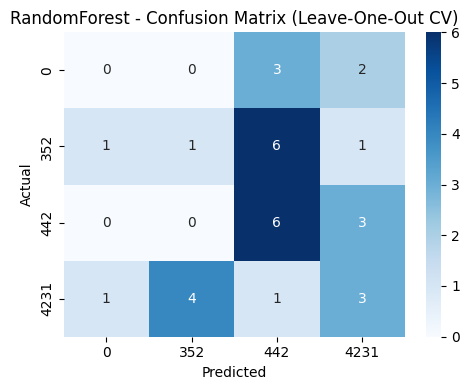


🔍 Running GridSearchCV for SVC...

✅ SVC Results
Best Score (Mean CV Accuracy): 0.2812
Best Params: {'clf__C': 0.1, 'clf__kernel': 'linear'}
Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.20      0.20         5
         352       0.30      0.33      0.32         9
         442       0.30      0.33      0.32         9
        4231       0.29      0.22      0.25         9

    accuracy                           0.28        32
   macro avg       0.27      0.27      0.27        32
weighted avg       0.28      0.28      0.28        32



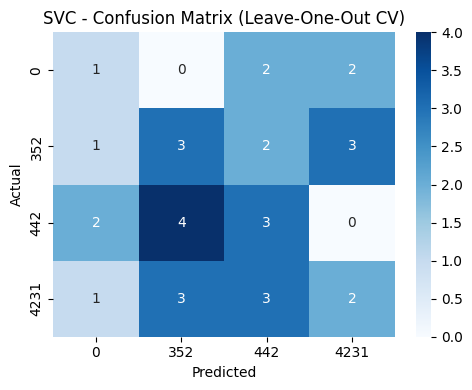


🔍 Running GridSearchCV for LogisticRegression...

✅ LogisticRegression Results
Best Score (Mean CV Accuracy): 0.3750
Best Params: {'clf__C': 1, 'clf__solver': 'liblinear'}
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
         352       0.33      0.33      0.33         9
         442       0.31      0.44      0.36         9
        4231       0.43      0.33      0.38         9

    accuracy                           0.38        32
   macro avg       0.43      0.38      0.39        32
weighted avg       0.40      0.38      0.38        32



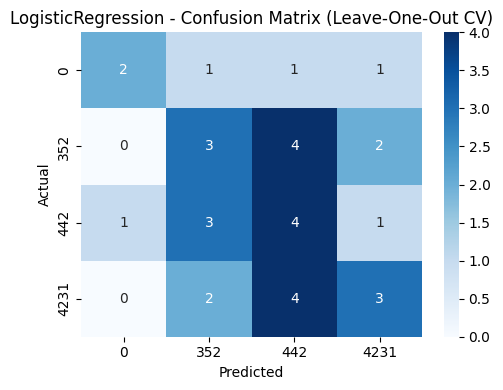


🔍 Running GridSearchCV for KNN...

✅ KNN Results
Best Score (Mean CV Accuracy): 0.2812
Best Params: {'clf__algorithm': 'auto', 'clf__leaf_size': 10, 'clf__metric': 'euclidean', 'clf__n_neighbors': 3, 'clf__weights': 'distance'}
Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.20      0.20         5
         352       0.44      0.44      0.44         9
         442       0.18      0.22      0.20         9
        4231       0.29      0.22      0.25         9

    accuracy                           0.28        32
   macro avg       0.28      0.27      0.27        32
weighted avg       0.29      0.28      0.28        32



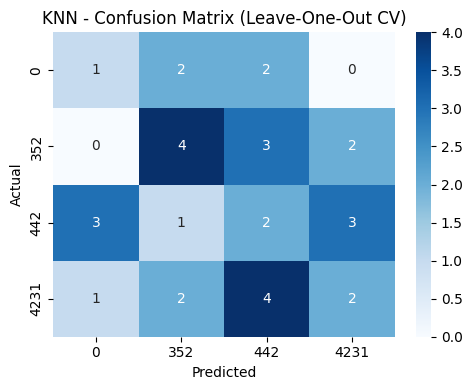

In [21]:
from sklearn.model_selection import GridSearchCV, LeaveOneOut, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_iris  # Example dataset, replace with your own

# ==== Load your dataset here ====
# Replace this with your actual X and y


# ==== Use Leave-One-Out Cross-Validation (LOO-CV) ====
cv = LeaveOneOut()

# ==== Define models with pipelines and parameter grids ====
models_and_parameters = {
    'RandomForest': {
        'pipeline': Pipeline([
            ('clf', RandomForestClassifier(random_state=42, class_weight='balanced')) #class balanced
        ]),
        'params': {
            'clf__n_estimators': [10, 20, 30, 40, 50, 100],
            'clf__max_depth': [None, 5, 10, 15, 20, 30, 50]
        }
    },
    'SVC': {
        'pipeline': Pipeline([
          ('scaler', StandardScaler()),      
            ('clf', SVC())
        ]),
        'params': {
            'clf__C': [0.1, 1],
            'clf__kernel': ['linear', 'rbf']
        }
    },
    'LogisticRegression': {
        'pipeline': Pipeline([
           ('scaler', StandardScaler()),      
            ('clf', LogisticRegression(max_iter=1000))
        ]),
        'params': {
            'clf__C': [0.1, 1],
            'clf__solver': ['liblinear']
        }
    },
    'KNN': {
        'pipeline': Pipeline([
           ('scaler', StandardScaler()),      
            ('clf', KNeighborsClassifier())
        ]),
        'params': {
            'clf__n_neighbors': [3, 5, 7, 9, 11, 13, 15],
            'clf__metric': ['euclidean', 'manhattan', 'chebyshev'],
            'clf__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'clf__leaf_size': [10, 20, 30, 40, 50],
            'clf__weights': ['uniform', 'distance']
        }
    }
}

# ==== Run GridSearchCV with Leave-One-Out Cross-Validation ====
results = {}

for name, mp in models_and_parameters.items():
    print(f"\n🔍 Running GridSearchCV for {name}...")
    
    # Grid Search with Leave-One-Out Cross-Validation
    grid = GridSearchCV(mp['pipeline'], mp['params'], cv=cv, scoring='accuracy', n_jobs=-1)
    grid.fit(X, y)
    
    best_model = grid.best_estimator_
    results[name] = {
        'best_score': grid.best_score_,
        'best_params': grid.best_params_,
        'best_estimator': best_model
    }
    
    # Predict using cross_val_predict for fair evaluation
    y_pred = cross_val_predict(best_model, X, y, cv=cv)
    
    # Confusion Matrix & Report
    cm = confusion_matrix(y, y_pred)
    print(f"\n✅ {name} Results")
    print(f"Best Score (Mean CV Accuracy): {grid.best_score_:.4f}")
    print(f"Best Params: {grid.best_params_}")
    print("Classification Report:")
    print(classification_report(y, y_pred))
    
    # Plot Confusion Matrix with true labels
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.title(f'{name} - Confusion Matrix (Leave-One-Out CV)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()



In [22]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse

def plot_means_with_covariances(data, file_key, cluster_id):
    fig, ax = plt.subplots(figsize=(10, 8))
    frames = data[file_key][cluster_id]

    for frame_idx, stats in frames.items():
        mean = np.array(stats['mean'])
        cov = np.array(stats['covariance'])

        # Plot mean
        ax.scatter(*mean, label=f"Frame {frame_idx}")

        # Plot covariance as ellipse
        lambda_, v = np.linalg.eig(cov)
        lambda_ = np.sqrt(lambda_)
        angle = np.degrees(np.arctan2(*v[:, 0][::-1]))
        ell = Ellipse(xy=mean,
                      width=lambda_[0]*2, height=lambda_[1]*2,
                      angle=angle, edgecolor='r', facecolor='none', lw=1)
        ax.add_patch(ell)

    ax.set_title(f"Cluster: {cluster_id} in File: {file_key}")
    ax.set_xlabel("X Position")
    ax.set_ylabel("Y Position")
    ax.legend()
    ax.grid(True)
    plt.axis('equal')
    plt.show()


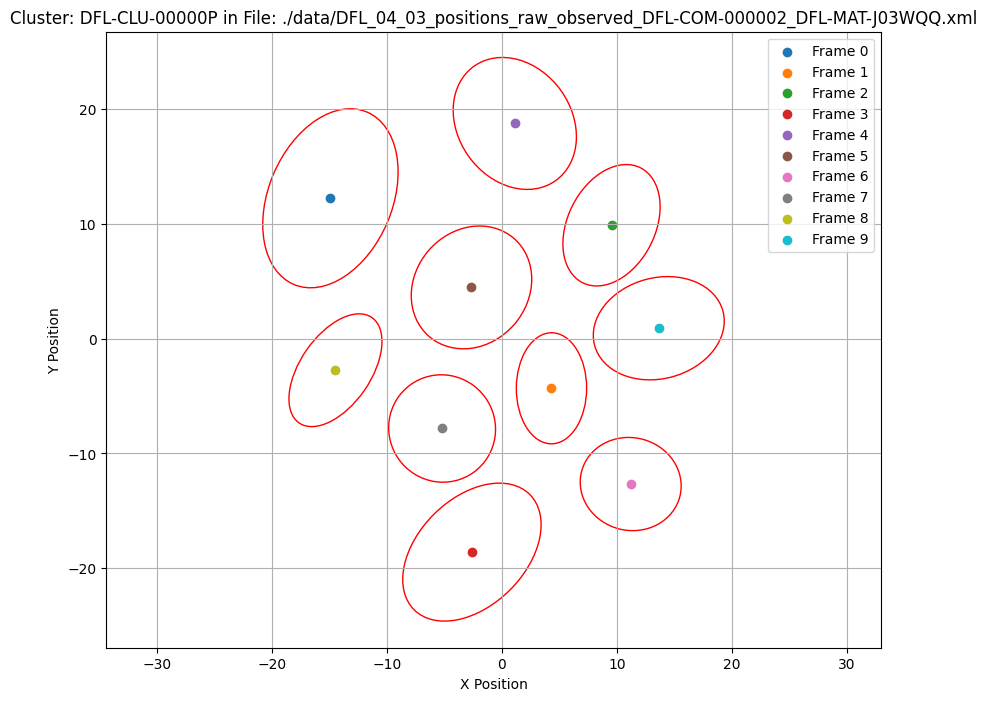

In [23]:
plot_means_with_covariances(
    data=data,
    file_key="./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WQQ.xml",
    cluster_id="DFL-CLU-00000P"
)
